# Melody detection
In this tutorial we will analyse the pitch contour of the predominant melody in an audio recording using the [PredominantPitchMelodia](http://essentia.upf.edu/documentation/reference/std_PredominantPitchMelodia.html) algorithm. This algorithm outputs a time series (sequence of values) with the instantaneous pitch value (in Hertz) of the perceived melody. It can be used with both monophonic and polyphonic signals.

In [1]:
# For embedding audio player
import IPython

# Plots
import matplotlib.pyplot as plt
from pylab import plot, show, figure, imshow
plt.rcParams['figure.figsize'] = (15, 6)

import numpy

Duration of the audio sample [sec]:
14.22859410430839


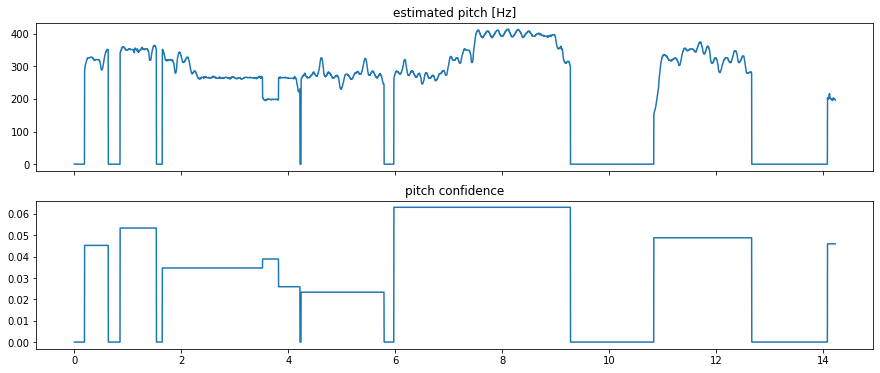

In [2]:
import essentia.standard as es

audiofile = '../../../test/audio/recorded/flamenco.mp3'

# Load audio file.
# It is recommended to apply equal-loudness filter for PredominantPitchMelodia.
loader = es.EqloudLoader(filename=audiofile, sampleRate=44100)
audio = loader()
print("Duration of the audio sample [sec]:")
print(len(audio)/44100.0)

# Extract the pitch curve
# PitchMelodia takes the entire audio signal as input (no frame-wise processing is required).

pitch_extractor = es.PredominantPitchMelodia(frameSize=2048, hopSize=128)
pitch_values, pitch_confidence = pitch_extractor(audio)

# Pitch is estimated on frames. Compute frame time positions.
pitch_times = numpy.linspace(0.0,len(audio)/44100.0,len(pitch_values) )

# Plot the estimated pitch contour and confidence over time.
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(pitch_times, pitch_values)
axarr[0].set_title('estimated pitch [Hz]')
axarr[1].plot(pitch_times, pitch_confidence)
axarr[1].set_title('pitch confidence')
plt.show()

The zero pitch value correspond to unvoiced audio segments with a very low pitch confidence according to the algorithm's estimation. You can force estimations on those as well by setting the `guessUnvoiced` parameter.

Let's listen to the estimated pitch and compare it to the original audio. To this end we will generate a sine wave signal following the estimated pitch, using the [mir_eval](https://pypi.org/project/mir_eval/) Python package (make sure to install it with `pip install mir_eval` to be able to run this code). 

In [3]:
IPython.display.Audio(audiofile)

In [4]:
from mir_eval.sonify import pitch_contour

from tempfile import TemporaryDirectory
temp_dir = TemporaryDirectory()

# Essentia operates with float32 ndarrays instead of float64, so let's cast it.
synthesized_melody = pitch_contour(pitch_times, pitch_values, 44100).astype(numpy.float32)[:len(audio)]
es.AudioWriter(filename=temp_dir.name + 'flamenco_melody.mp3', format='mp3')(es.StereoMuxer()(audio, synthesized_melody))

IPython.display.Audio(temp_dir.name + 'flamenco_melody.mp3')

## Note segmentation and converting to MIDI

The PredominantPitchMelodia algorithm outputs pitch values in Hz, but we can also convert it to MIDI notes using the [PitchContourSegmentation](https://essentia.upf.edu/documentation/reference/std_PitchContourSegmentation.html) algorithm. Here is the default output it provides (tune the parameters for better note estimation).

In [5]:
onsets, durations, notes = es.PitchContourSegmentation(hopSize=128)(pitch_values, audio)
print("MIDI notes:", notes) # Midi pitch number
print("MIDI note onsets:", onsets)
print("MIDI note durations:", durations)

MIDI notes: [63. 64. 65. 65. 64. 63. 63. 64. 62. 60. 55. 60. 60. 61. 63. 61. 60. 59.
 61. 60. 61. 63. 61. 60. 61. 63. 61. 61. 60. 60. 60. 61. 63. 65. 65. 68.
 67. 65. 63. 55. 63. 64. 63. 65. 66. 65. 63. 62. 63. 65. 64. 61. 56.]
MIDI note onsets: [ 0.19156462  0.49052155  0.8562358   1.3960998   1.6457143   1.7502041
  1.8634014   1.9620862   2.1507483   2.2871656   3.5236282   3.822585
  4.2405443   4.4640365   4.571429    4.6701136   4.8297505   4.954558
  5.0532427   5.16644     5.265125    5.3928347   5.4915195   5.642449
  5.976236    6.135873    6.2345576   6.382585    6.4899774   6.588662
  6.7453966   6.8440814   6.986304    7.250431    7.4187756   7.5174603
  7.616145    9.00644     9.13415    10.8379135  10.942404   11.041088
 11.296508   11.395193   11.668027   11.766712   11.894422   12.036644
 12.135329   12.321089   12.419773   12.547483   14.085805  ]
MIDI note durations: [0.29315192 0.14222223 0.5340589  0.13641724 0.09868481 0.10739229
 0.09287982 0.18285714 0.13061224 

We can now export results to a MIDI file. We will use [mido](https://mido.readthedocs.io/) Python package (which you can install with `pip install mido`) to do generate the `.mid` file. You can test the result using the generated `.mid` file in a DAW.

In [6]:
import mido

PPQ = 96 # Pulses per quarter note.
BPM = 120 # Assuming a default tempo in Ableton to build a MIDI clip.
tempo = mido.bpm2tempo(BPM) # Microseconds per beat.

# Compute onsets and offsets for all MIDI notes in ticks.
# Relative tick positions start from time 0.
offsets = onsets + durations
silence_durations = list(onsets[1:] - offsets[:-1]) + [0]

mid = mido.MidiFile()
track = mido.MidiTrack()
mid.tracks.append(track)

for note, onset, duration, silence_duration in zip(list(notes), list(onsets), list(durations), silence_durations):
    track.append(mido.Message('note_on', note=int(note), velocity=64, 
                              time=int(mido.second2tick(duration, PPQ, tempo))))
    track.append(mido.Message('note_off', note=int(note), 
                              time=int(mido.second2tick(silence_duration, PPQ, tempo))))

midi_file = temp_dir.name + '/extracted_melody.mid'
mid.save(midi_file)
print("MIDI file location:", midi_file)

MIDI file location: /tmp/tmpf6zzwakg/extracted_melody.mid
